In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#colors!

c_d = '#1b9e77'
c_i = '#d95f02'
c_c = '#7570b3'

## Import data

In [36]:
# research article data

domestic_research = pd.read_csv('data/domestic_brazil_research.csv')
international_research = pd.read_csv('data/international_brazil_research.csv')
collaborative_research = pd.read_csv('data/collaboration_brazil_research.csv')

domestic_research = domestic_research[domestic_research['Publication Year'] < 2022]
international_research = international_research[international_research['Publication Year'] < 2022]
collaborative_research = collaborative_research[collaborative_research['Publication Year'] < 2022]

domestic_research = domestic_research.reset_index(drop=True)
international_research = international_research.reset_index(drop=True)
collaborative_research = collaborative_research.reset_index(drop=True)


# deforestation data

deforestation_df = pd.read_csv('data/brazil-world-bank-forest-area-percentage.csv')

/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/740879034.py:3: DtypeWarning: Columns (13,20,48,52,58) have mixed types. Specify dtype option on import or set low_memory=False.
  domestic_research = pd.read_csv('data/domestic_brazil_research.csv')


## Pre-processing data

Aligning year ranges between the data

In [37]:
min_year = max([min(domestic_research['Publication Year']), min(international_research['Publication Year']), min(collaborative_research['Publication Year']), min(deforestation_df['year'])])

deforestation_df = deforestation_df[deforestation_df['year']  >= min_year]
domestic_research = domestic_research[domestic_research['Publication Year'] >= min_year]
international_research = international_research[international_research['Publication Year'] >= min_year]
collaborative_research = collaborative_research[collaborative_research['Publication Year'] >= min_year]

deforestation_df = deforestation_df.reset_index(drop=True)
domestic_research = domestic_research.reset_index(drop=True)
international_research = international_research.reset_index(drop=True)
collaborative_research = collaborative_research.reset_index(drop=True)

Dataframes to hold final predictor/response data

In [38]:
len(deforestation_df)

24

In [39]:
deforestation_df.columns

Index(['year', 'Forest area (% of land area)'], dtype='object')

In [40]:
domestic_research.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Publication Type', 'Authors',
       'Book Authors', 'Book Editors', 'Book Group Authors',
       'Author Full Names', 'Book Author Full Names', 'Group Authors',
       'Article Title', 'Source Title', 'Book Series Title',
       'Book Series Subtitle', 'Language', 'Document Type', 'Conference Title',
       'Conference Date', 'Conference Location', 'Conference Sponsor',
       'Conference Host', 'Author Keywords', 'Keywords Plus', 'Abstract',
       'Addresses', 'Affiliations', 'Reprint Addresses', 'Email Addresses',
       'Researcher Ids', 'ORCIDs', 'Funding Orgs', 'Funding Text',
       'Cited References', 'Cited Reference Count', 'Times Cited, WoS Core',
       'Times Cited, All Databases', '180 Day Usage Count',
       'Since 2013 Usage Count', 'Publisher', 'Publisher City',
       'Publisher Address', 'ISSN', 'eISSN', 'ISBN', 'Journal Abbreviation',
       'Journal ISO Abbreviation', 'Publication Date', 'Publication Year',
       'Volume', '

In [41]:
len(np.arange(min_year, 2021))

24

In [43]:
domestic_df = pd.DataFrame({'Year': np.arange(min_year, 2021), 'Deforestation_Rate': deforestation_df['Forest area (% of land area)']})
international_df = pd.DataFrame({'Year': np.arange(min_year, 2021), 'Deforestation_Rate': deforestation_df['Forest area (% of land area)']})
collaborative_df = pd.DataFrame({'Year': np.arange(min_year, 2021), 'Deforestation_Rate': deforestation_df['Forest area (% of land area)']})

Processing article data to get AR index citation metric

In [44]:
def calculate_AR_index(citations, year):
    
    citations = np.array(citations)
    n = citations.shape[0]
    array = np.arange(1, n+1)

    # reverse sorting
    citations = np.sort(citations)[::-1]           

    # computing h-index
    h_idx = np.max(np.minimum(citations, array))
    
    # computing AR index
    paper_age = 2022 - year
    AR = np.sqrt(sum(citations[0:h_idx-1]) / (paper_age))
    
    return AR 

In [45]:
def process_article_data(article_df, year_list):
    
    AR_index_list = []
    
    for year in year_list:
        article_df_year = article_df[article_df['Publication Year'] == year]
        AR_index_list.append(calculate_AR_index(article_df_year['Times Cited, All Databases'], year))
        
    return AR_index_list

In [46]:
domestic_df['AR_Index'] = process_article_data(domestic_research, domestic_df['Year'])

international_df['AR_Index'] = process_article_data(international_research, international_df['Year'])

collaborative_df['AR_Index'] = process_article_data(collaborative_research, collaborative_df['Year'])

### Making time-shifted variables

In [47]:
# def get_shift(df, steps_back, min_year):
    
#     df_shifted = pd.DataFrame({'Year': np.arange(min_year+steps_back, 2021)})
    
#     deforestation_list = np.asarray(df['Deforestation_Rate'])
#     deforestation_list = deforestation_list[steps_back:len(deforestation_list)]
#     df_shifted['Deforestation_Rate'] = deforestation_list
    
#     AR_list = np.asarray(df['AR_Index'])
#     AR_list = AR_list[0:len(AR_list)-steps_back]
#     df_shifted[f'AR_Index_{steps_back}_Year_Prev'] = AR_list
    
#     return df_shifted

In [48]:
# domestic_df_list = [domestic_df]
# international_df_list = [international_df]
# collaborative_df_list = [collaborative_df]

# # time shifts of 1-5 years
# for i in range(1, 6):

#     domestic_df_list.append(get_shift(domestic_df, i, min_year)) 
#     international_df_list.append(get_shift(international_df, i, min_year)) 
#     collaborative_df_list.append(get_shift(collaborative_df, i, min_year)) 

In [189]:
def get_forest_loss(df, shift_year, country_area):
    shifted_df = np.asarray(df['Deforestation_Rate'][:-shift_year])
    df_rate = df.loc[shift_year:, :].copy()
    df_rate.loc[:,f'previous_{shift_year}_year_forest_rate'] = shifted_df
    df_rate.loc[:,f'forest_loss_in_km_from_previous_{shift_year}_year'] = np.abs(df_rate['Deforestation_Rate']*country_area
                                                                         -df_rate[f'previous_{shift_year}_year_forest_rate']*country_area)
    df_rate_clean = pd.DataFrame({'Year':[],'forest_loss_in_km':[], 'AR_Index':[]})
    df_rate_clean['Year'] = df_rate.loc[:,'Year']
    df_rate_clean['forest_loss_in_km'] = df_rate.loc[:,f'forest_loss_in_km_from_previous_{shift_year}_year']
    df_rate_clean['AR_Index'] = df_rate.loc[:,'AR_Index']
    
    return df_rate_clean
    

In [190]:
domestic_df_rate = get_forest_loss(domestic_df, 1, brazil_land_area)
international_df_rate = get_forest_loss(international_df, 1, brazil_land_area)
collaborative_df_rate = get_forest_loss(collaborative_df, 1, brazil_land_area)

In [198]:
def get_shift(df, steps_back, min_year):
    
    df_shifted = pd.DataFrame({'Year': np.arange(min_year+steps_back, 2021)})
    
    deforestation_list = np.asarray(df['forest_loss_in_km'])
    deforestation_list = deforestation_list[steps_back:len(deforestation_list)]
    df_shifted['forest_loss_in_km'] = deforestation_list
    
    AR_list = np.asarray(df['AR_Index'])
    AR_list = AR_list[0:len(AR_list)-steps_back]
    df_shifted[f'AR_Index_{steps_back}_Year_Prev'] = AR_list
    
    return df_shifted

In [199]:
international_df_rate['forest_loss_in_km']

1     3845112.700
2     3845112.615
3     3845112.700
4     4017845.450
5     4017845.535
6     4017845.450
7     4017845.450
8     4017845.450
9     4017845.535
10    4017845.450
11    4017845.450
12    4017845.535
13    4017845.450
14    1565303.985
15    1565304.070
16    1565303.985
17    1565303.985
18    1565303.985
19    1833296.660
20    2024284.095
21    1057855.005
22    1274165.045
23    1198909.105
Name: forest_loss_in_km, dtype: float64

In [200]:
international_df_rate.head(2)

Year  forest_loss_in_km   AR_Index
1  1998.0        3845112.700  15.459625
2  1999.0        3845112.615  16.479236

In [203]:
domestic_df_list = [domestic_df_rate]
international_df_list = [international_df_rate]
collaborative_df_list = [collaborative_df_rate]

for i in range(1, 6):

    domestic_df_list.append(get_shift(domestic_df_rate, i, min_year+1)) 
    international_df_list.append(get_shift(international_df_rate, i, min_year+1)) 
    collaborative_df_list.append(get_shift(collaborative_df_rate, i, min_year+1)) 

## Plots of raw data

### Deforestation rate timeseries

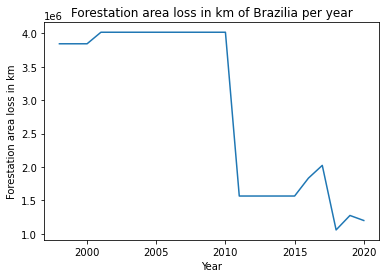

In [235]:
# brazil_land_area = 8.5*(10**6)

# shifted_forest_rate = np.asarray(domestic_df['Deforestation_Rate'][:-1])
# domestic_df_rate = domestic_df[1:]
# domestic_df_rate['previous_year_forest_rate'] = shifted_forest_rate
# domestic_df_rate['forest_loss_in_km'] = np.abs(domestic_df_rate['Deforestation_Rate']*brazil_land_area - 
#                                                 domestic_df_rate['previous_year_forest_rate']*brazil_land_area)


plt.plot(domestic_df_rate['Year'], domestic_df_rate['forest_loss_in_km'])
plt.title(r'Forestation area loss in km of Brazilia per year')
plt.xlabel('Year')
plt.ylabel(r'Forestation area loss in km')
plt.show()

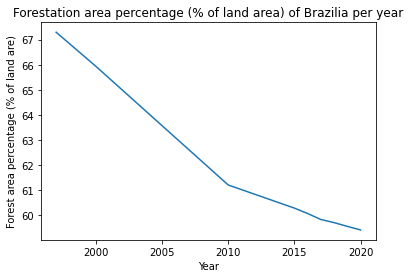

In [73]:
# plt.plot(domestic_df['Year'], domestic_df['Deforestation_Rate'])
# plt.title(r'Forestation area percentage (% of land area) of Brazilia per year')
# plt.xlabel('Year')
# plt.ylabel(r'Forest area percentage (% of land are)')
# plt.show()

### AR index timeseries

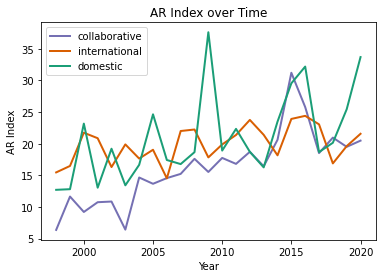

In [206]:
plt.plot(collaborative_df_rate['Year'], collaborative_df_rate['AR_Index'], color=c_c, linewidth=2, label='collaborative')
plt.plot(international_df_rate['Year'], international_df_rate['AR_Index'], color=c_i, linewidth=2, label='international')
plt.plot(domestic_df_rate['Year'], domestic_df_rate['AR_Index'], color=c_d, linewidth=2, label='domestic')
plt.title('AR Index over Time')
plt.xlabel('Year')
plt.ylabel('AR Index')
plt.legend()
         
plt.show()

### Scatter plots of AR Index vs. Deforestation rate

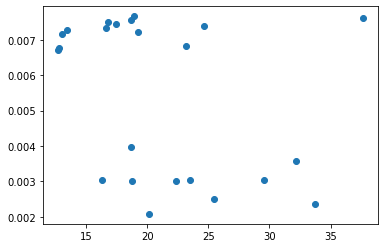

In [109]:
plt.scatter(domestic_df_rate['AR_Index'], domestic_df_rate['forest_rate_change'])

In [208]:
domestic_df_list[0]

Year  forest_loss_in_km   AR_Index
1   1998.0        3845112.700  12.704986
2   1999.0        3845112.615  12.806248
3   2000.0        3845112.700  23.173260
4   2001.0        4017845.450  13.042057
5   2002.0        4017845.535  19.202864
6   2003.0        4017845.450  13.416408
7   2004.0        4017845.450  16.656664
8   2005.0        4017845.450  24.640951
9   2006.0        4017845.535  17.419458
10  2007.0        4017845.450  16.774981
11  2008.0        4017845.450  18.662414
12  2009.0        4017845.535  37.617508
13  2010.0        4017845.450  18.909874
14  2011.0        1565303.985  22.342377
15  2012.0        1565304.070  18.710959
16  2013.0        1565303.985  16.254914
17  2014.0        1565303.985  23.486698
18  2015.0        1565303.985  29.546573
19  2016.0        1833296.660  32.189543
20  2017.0        2024284.095  18.676188
21  2018.0        1057855.005  20.143237
22  2019.0        1274165.045  25.442746
23  2020.0        1198909.105  33.689761

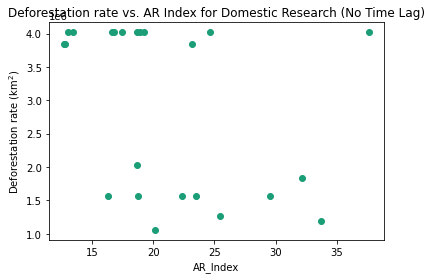

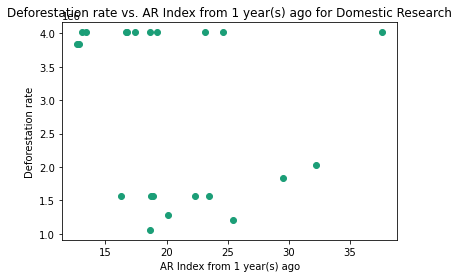

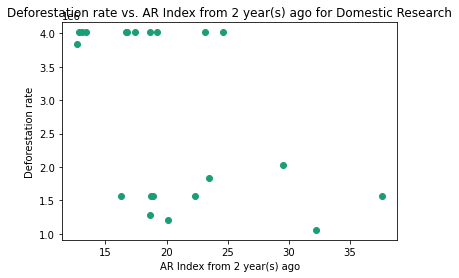

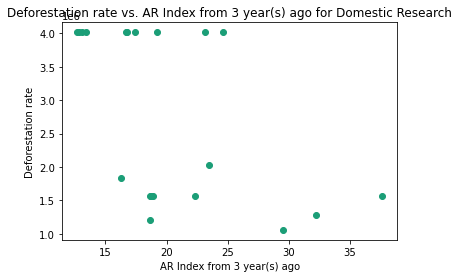

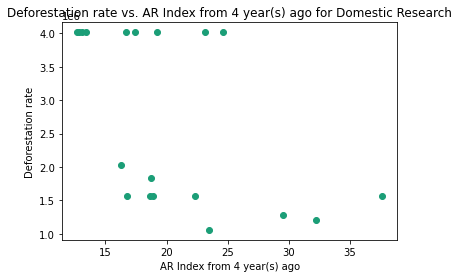

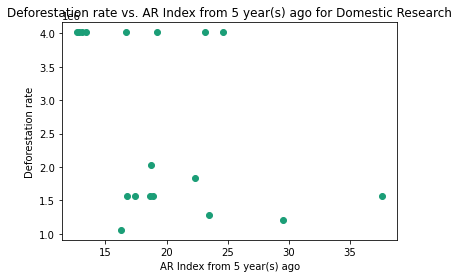

In [209]:
for i in range(0, 6):
    if i==0:
        plt.scatter(domestic_df_list[i]['AR_Index'], domestic_df_list[i]['forest_loss_in_km'], color=c_d)
        plt.xlabel('AR_Index')
        plt.ylabel(r'Deforestation rate (km$^2$)')
        plt.title('Deforestation rate vs. AR Index for Domestic Research (No Time Lag)')
        plt.show()
    else:
        plt.scatter(domestic_df_list[i][f'AR_Index_{i}_Year_Prev'], domestic_df_list[i]['forest_loss_in_km'], color=c_d)
        plt.title(f'Deforestation rate vs. AR Index from {i} year(s) ago for Domestic Research')
        plt.xlabel(f'AR Index from {i} year(s) ago')
        plt.ylabel('Deforestation rate')
        plt.show()

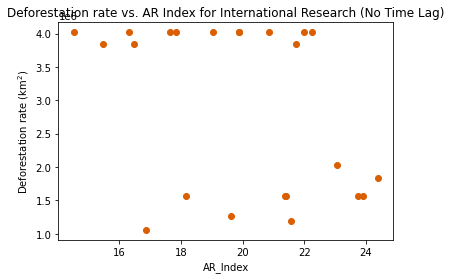

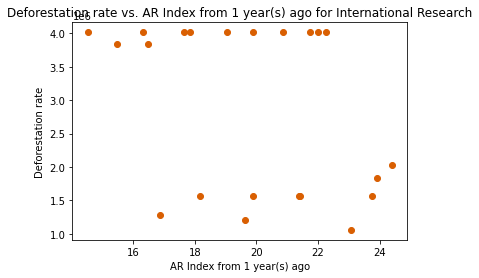

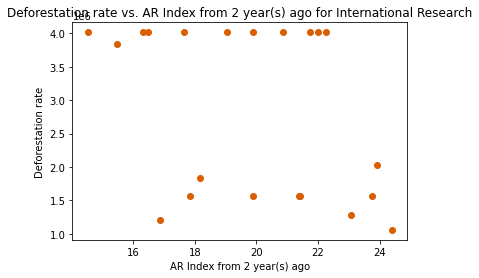

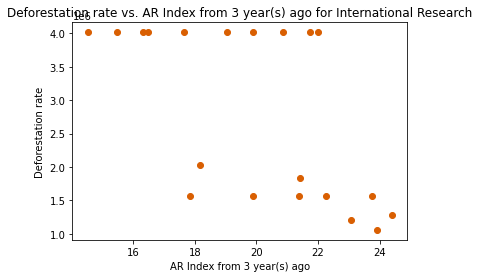

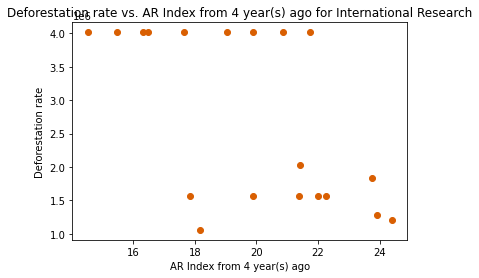

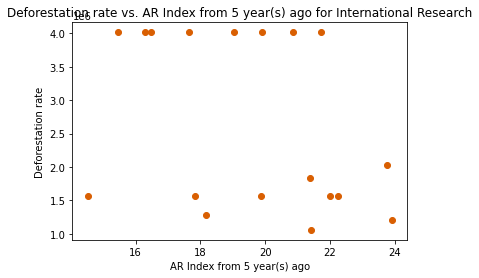

In [210]:
for i in range(0, 6):
    if i==0:
        plt.scatter(international_df_list[i]['AR_Index'], international_df_list[i]['forest_loss_in_km'], color=c_i)
        plt.xlabel('AR_Index')
        plt.ylabel(r'Deforestation rate (km$^2$)')
        plt.title('Deforestation rate vs. AR Index for International Research (No Time Lag)')
        plt.show()
    else:
        plt.scatter(international_df_list[i][f'AR_Index_{i}_Year_Prev'], international_df_list[i]['forest_loss_in_km'], color=c_i)
        plt.title(f'Deforestation rate vs. AR Index from {i} year(s) ago for International Research')
        plt.xlabel(f'AR Index from {i} year(s) ago')
        plt.ylabel('Deforestation rate')
        plt.show()

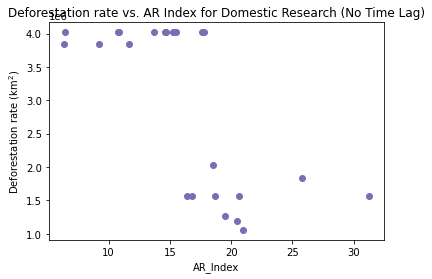

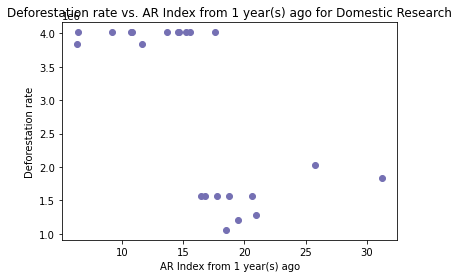

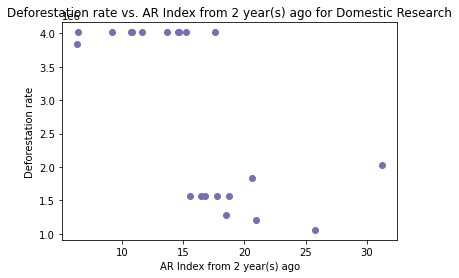

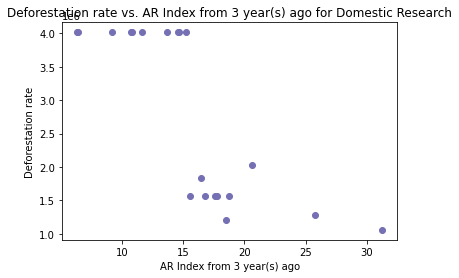

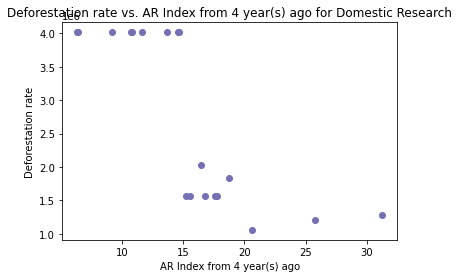

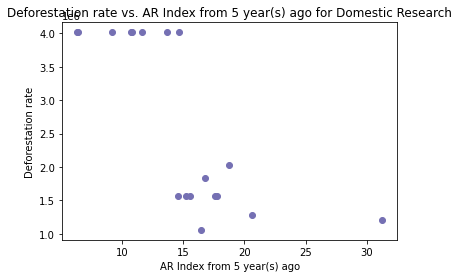

In [211]:
for i in range(0, 6):
    if i==0:
        plt.scatter(collaborative_df_list[i]['AR_Index'], collaborative_df_list[i]['forest_loss_in_km'], color=c_c)
        plt.xlabel('AR_Index')
        plt.ylabel(r'Deforestation rate (km$^2$)')
        plt.title('Deforestation rate vs. AR Index for Domestic Research (No Time Lag)')
        plt.show()
    else:
        plt.scatter(collaborative_df_list[i][f'AR_Index_{i}_Year_Prev'], collaborative_df_list[i]['forest_loss_in_km'], color=c_c)
        plt.title(f'Deforestation rate vs. AR Index from {i} year(s) ago for Domestic Research')
        plt.xlabel(f'AR Index from {i} year(s) ago')
        plt.ylabel('Deforestation rate')
        plt.show()

# Model fitting

In [212]:
import statsmodels.api as sm
from scipy.interpolate import interp1d
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

import patsy as pt

In [213]:
domestic_df_list[1].columns

Index(['Year', 'forest_loss_in_km', 'AR_Index_1_Year_Prev'], dtype='object')

## Linear regression and significance testing

### Domestic

                            OLS Regression Results                            
Dep. Variable:      forest_loss_in_km   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     3.646
Date:                Wed, 04 May 2022   Prob (F-statistic):             0.0700
Time:                        11:34:39   Log-Likelihood:                -353.35
No. Observations:                  23   AIC:                             710.7
Df Residuals:                      21   BIC:                             713.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.402e+06    8.2e+05      5.369      0.0

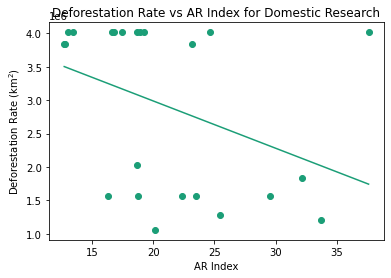

                            OLS Regression Results                            
Dep. Variable:      forest_loss_in_km   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.154
Date:                Wed, 04 May 2022   Prob (F-statistic):              0.295
Time:                        11:34:40   Log-Likelihood:                -339.33
No. Observations:                  22   AIC:                             682.7
Df Residuals:                      20   BIC:                             684.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 3.817e+06 

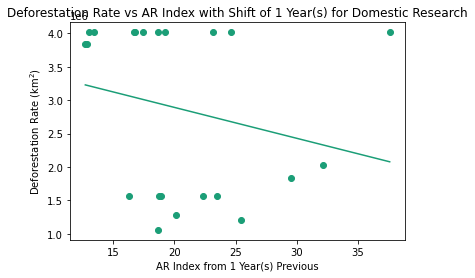

                            OLS Regression Results                            
Dep. Variable:      forest_loss_in_km   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     6.564
Date:                Wed, 04 May 2022   Prob (F-statistic):             0.0191
Time:                        11:34:40   Log-Likelihood:                -321.55
No. Observations:                  21   AIC:                             647.1
Df Residuals:                      19   BIC:                             649.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 4.856e+06 

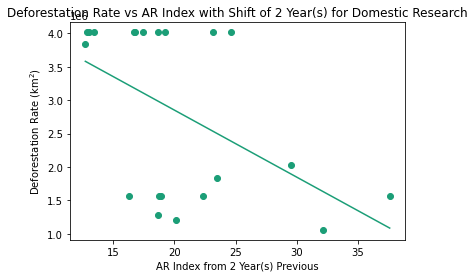

                            OLS Regression Results                            
Dep. Variable:      forest_loss_in_km   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     7.462
Date:                Wed, 04 May 2022   Prob (F-statistic):             0.0137
Time:                        11:34:40   Log-Likelihood:                -305.89
No. Observations:                  20   AIC:                             615.8
Df Residuals:                      18   BIC:                             617.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 4.908e+06 

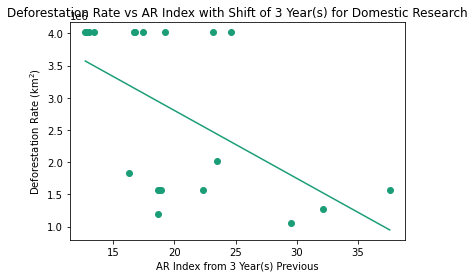

/Applications/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                            OLS Regression Results                            
Dep. Variable:      forest_loss_in_km   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     6.913
Date:                Wed, 04 May 2022   Prob (F-statistic):             0.0176
Time:                        11:34:40   Log-Likelihood:                -290.63
No. Observations:                  19   AIC:                             585.3
Df Residuals:                      17   BIC:                             587.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 4.785e+06 

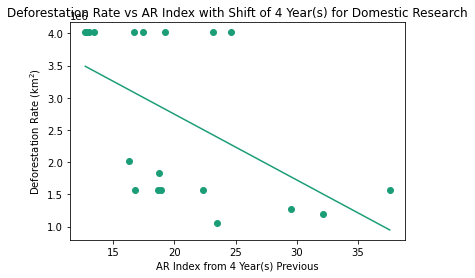

                            OLS Regression Results                            
Dep. Variable:      forest_loss_in_km   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     3.204
Date:                Wed, 04 May 2022   Prob (F-statistic):             0.0924
Time:                        11:34:41   Log-Likelihood:                -276.69
No. Observations:                  18   AIC:                             557.4
Df Residuals:                      16   BIC:                             559.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 4.264e+06 

/Applications/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


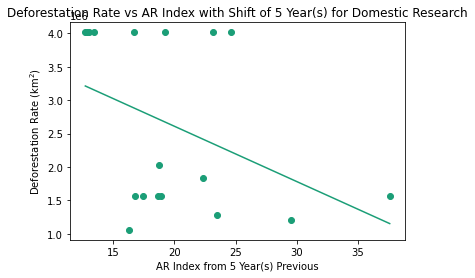

In [216]:
X = domestic_df_list[0]['AR_Index']
y = domestic_df_list[0]['forest_loss_in_km']
sk_model = sm.OLS(y, sm.add_constant(X))
results = sk_model.fit()
print(results.summary())
f = interp1d(domestic_df_list[0]['AR_Index'], results.predict(sm.add_constant(domestic_df_list[0]['AR_Index'])), bounds_error=False)
y_preds = f(domestic_df_list[0]['AR_Index'])
X_vis, y_preds = zip(*sorted(zip(domestic_df_list[0]['AR_Index'], y_preds)))
plt.scatter(domestic_df_list[0]['AR_Index'], domestic_df_list[0]['forest_loss_in_km'], color=c_d)
plt.plot(X_vis, y_preds, label='Predicted Rate', color=c_d)
plt.title(f'Deforestation Rate vs AR Index for Domestic Research')
plt.xlabel('AR Index')
plt.ylabel(r'Deforestation Rate (km$^2$)')
plt.show()

for i in range(1,6):
    X = domestic_df_list[i][f'AR_Index_{i}_Year_Prev']
    y = domestic_df_list[i]['forest_loss_in_km']
    sk_model = sm.OLS(y, sm.add_constant(X))
    results = sk_model.fit()
    print(results.summary())
    
    f = interp1d(domestic_df_list[i][f'AR_Index_{i}_Year_Prev'], results.predict(sm.add_constant(domestic_df_list[i][f'AR_Index_{i}_Year_Prev'])), bounds_error=False)
    y_preds = f(domestic_df_list[i][f'AR_Index_{i}_Year_Prev'])
    X_vis, y_preds = zip(*sorted(zip(domestic_df_list[i][f'AR_Index_{i}_Year_Prev'], y_preds)))
    plt.scatter(domestic_df_list[i][f'AR_Index_{i}_Year_Prev'], domestic_df_list[i]['forest_loss_in_km'], color=c_d)
    plt.plot(X_vis, y_preds, label='Predicted Rate', color=c_d)
    plt.title(f'Deforestation Rate vs AR Index with Shift of {i} Year(s) for Domestic Research')
    plt.xlabel(f'AR Index from {i} Year(s) Previous')
    plt.ylabel(r'Deforestation Rate (km$^2$)')
    plt.show()

### International

                            OLS Regression Results                            
Dep. Variable:      forest_loss_in_km   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     4.147
Date:                Wed, 04 May 2022   Prob (F-statistic):             0.0545
Time:                        11:35:47   Log-Likelihood:                -353.12
No. Observations:                  23   AIC:                             710.2
Df Residuals:                      21   BIC:                             712.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.489e+06   1.77e+06      3.656      0.0

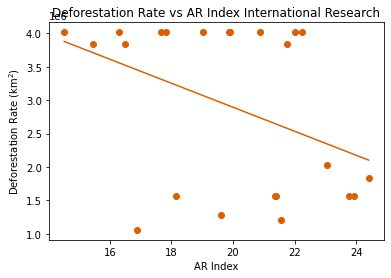

                            OLS Regression Results                            
Dep. Variable:      forest_loss_in_km   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     3.735
Date:                Wed, 04 May 2022   Prob (F-statistic):             0.0676
Time:                        11:35:47   Log-Likelihood:                -338.06
No. Observations:                  22   AIC:                             680.1
Df Residuals:                      20   BIC:                             682.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 6.333e+06 

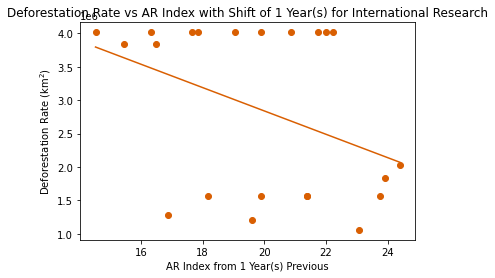

                            OLS Regression Results                            
Dep. Variable:      forest_loss_in_km   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     3.449
Date:                Wed, 04 May 2022   Prob (F-statistic):             0.0789
Time:                        11:35:47   Log-Likelihood:                -322.92
No. Observations:                  21   AIC:                             649.8
Df Residuals:                      19   BIC:                             651.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 6.196e+06 

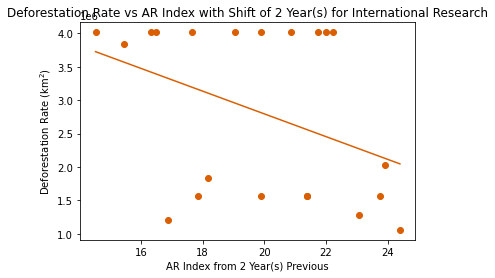

                            OLS Regression Results                            
Dep. Variable:      forest_loss_in_km   R-squared:                       0.369
Model:                            OLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                     10.51
Date:                Wed, 04 May 2022   Prob (F-statistic):            0.00453
Time:                        11:35:47   Log-Likelihood:                -304.76
No. Observations:                  20   AIC:                             613.5
Df Residuals:                      18   BIC:                             615.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 8.091e+06 

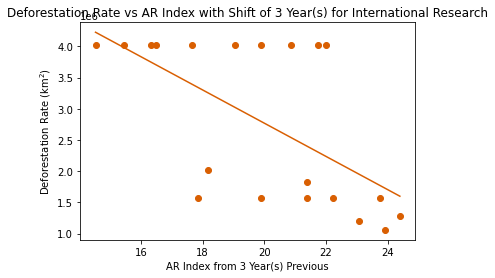

                            OLS Regression Results                            
Dep. Variable:      forest_loss_in_km   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     9.337
Date:                Wed, 04 May 2022   Prob (F-statistic):            0.00715
Time:                        11:35:48   Log-Likelihood:                -289.72
No. Observations:                  19   AIC:                             583.4
Df Residuals:                      17   BIC:                             585.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 7.902e+06 

/Applications/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


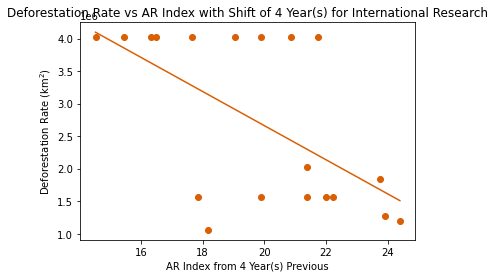

/Applications/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                            OLS Regression Results                            
Dep. Variable:      forest_loss_in_km   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     2.416
Date:                Wed, 04 May 2022   Prob (F-statistic):              0.140
Time:                        11:35:48   Log-Likelihood:                -277.07
No. Observations:                  18   AIC:                             558.1
Df Residuals:                      16   BIC:                             559.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 5.896e+06 

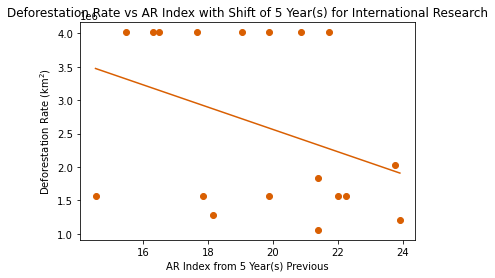

In [217]:
X = international_df_list[0]['AR_Index']
y = international_df_list[0]['forest_loss_in_km']
sk_model = sm.OLS(y, sm.add_constant(X))
results = sk_model.fit()
print(results.summary())
f = interp1d(international_df_list[0]['AR_Index'], results.predict(sm.add_constant(international_df_list[0]['AR_Index'])), bounds_error=False)
y_preds = f(international_df_list[0]['AR_Index'])
X_vis, y_preds = zip(*sorted(zip(international_df_list[0]['AR_Index'], y_preds)))
plt.scatter(international_df_list[0]['AR_Index'], international_df_list[0]['forest_loss_in_km'], color=c_i)
plt.plot(X_vis, y_preds, label='Predicted Rate', color=c_i)
plt.title(f'Deforestation Rate vs AR Index International Research')
plt.xlabel('AR Index')
plt.ylabel(r'Deforestation Rate (km$^2$)')
plt.show()

for i in range(1,6):
    X = international_df_list[i][f'AR_Index_{i}_Year_Prev']
    y = international_df_list[i]['forest_loss_in_km']
    sk_model = sm.OLS(y, sm.add_constant(X))
    results = sk_model.fit()
    print(results.summary())
    
    f = interp1d(international_df_list[i][f'AR_Index_{i}_Year_Prev'], results.predict(sm.add_constant(international_df_list[i][f'AR_Index_{i}_Year_Prev'])), bounds_error=False)
    y_preds = f(international_df_list[i][f'AR_Index_{i}_Year_Prev'])
    X_vis, y_preds = zip(*sorted(zip(international_df_list[i][f'AR_Index_{i}_Year_Prev'], y_preds)))
    plt.scatter(international_df_list[i][f'AR_Index_{i}_Year_Prev'], international_df_list[i]['forest_loss_in_km'], color=c_i)
    plt.plot(X_vis, y_preds, label='Predicted Rate', color=c_i)
    plt.title(f'Deforestation Rate vs AR Index with Shift of {i} Year(s) for International Research')
    plt.xlabel(f'AR Index from {i} Year(s) Previous')
    plt.ylabel(r'Deforestation Rate (km$^2$)')
    plt.show()

### Collaborative

                            OLS Regression Results                            
Dep. Variable:      forest_loss_in_km   R-squared:                       0.489
Model:                            OLS   Adj. R-squared:                  0.464
Method:                 Least Squares   F-statistic:                     20.06
Date:                Wed, 04 May 2022   Prob (F-statistic):           0.000207
Time:                        11:37:04   Log-Likelihood:                -347.48
No. Observations:                  23   AIC:                             699.0
Df Residuals:                      21   BIC:                             701.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.376e+06   5.83e+05      9.218      0.0

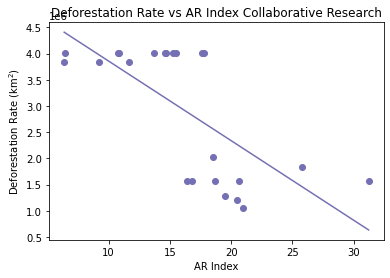

                            OLS Regression Results                            
Dep. Variable:      forest_loss_in_km   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.429
Method:                 Least Squares   F-statistic:                     16.80
Date:                Wed, 04 May 2022   Prob (F-statistic):           0.000559
Time:                        11:37:04   Log-Likelihood:                -333.24
No. Observations:                  22   AIC:                             670.5
Df Residuals:                      20   BIC:                             672.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 5.222e+06 

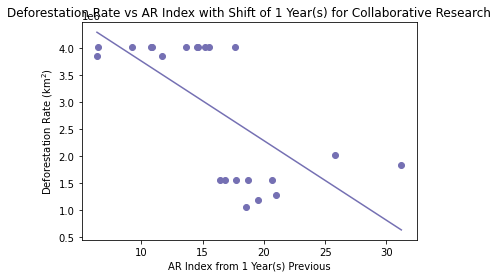

                            OLS Regression Results                            
Dep. Variable:      forest_loss_in_km   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                     16.84
Date:                Wed, 04 May 2022   Prob (F-statistic):           0.000604
Time:                        11:37:05   Log-Likelihood:                -318.00
No. Observations:                  21   AIC:                             640.0
Df Residuals:                      19   BIC:                             642.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 5.171e+06 

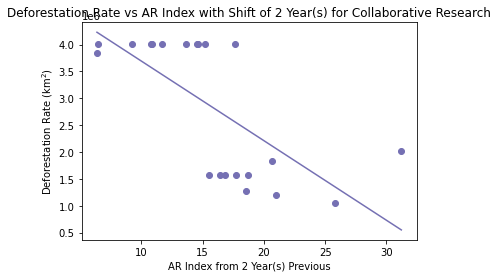

                            OLS Regression Results                            
Dep. Variable:      forest_loss_in_km   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.582
Method:                 Least Squares   F-statistic:                     27.45
Date:                Wed, 04 May 2022   Prob (F-statistic):           5.55e-05
Time:                        11:37:05   Log-Likelihood:                -300.10
No. Observations:                  20   AIC:                             604.2
Df Residuals:                      18   BIC:                             606.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 5.398e+06 

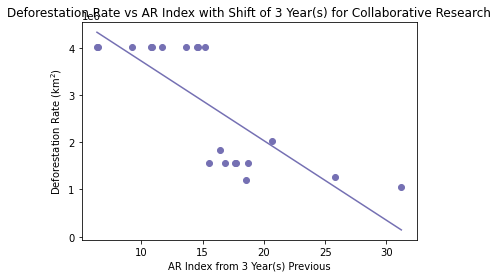

/Applications/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                            OLS Regression Results                            
Dep. Variable:      forest_loss_in_km   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.576
Method:                 Least Squares   F-statistic:                     25.49
Date:                Wed, 04 May 2022   Prob (F-statistic):           9.90e-05
Time:                        11:37:05   Log-Likelihood:                -285.17
No. Observations:                  19   AIC:                             574.3
Df Residuals:                      17   BIC:                             576.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 5.247e+06 

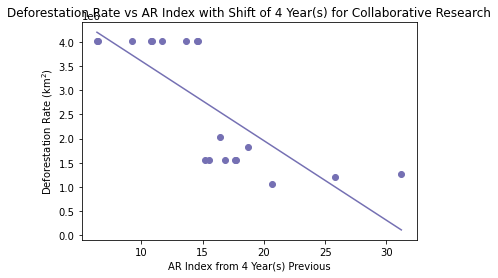

                            OLS Regression Results                            
Dep. Variable:      forest_loss_in_km   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.521
Method:                 Least Squares   F-statistic:                     19.49
Date:                Wed, 04 May 2022   Prob (F-statistic):           0.000434
Time:                        11:37:06   Log-Likelihood:                -271.17
No. Observations:                  18   AIC:                             546.3
Df Residuals:                      16   BIC:                             548.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 5.121e+06 

/Applications/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


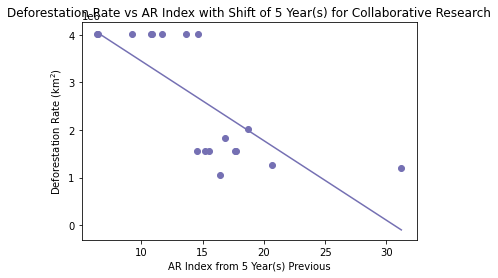

In [218]:
X = collaborative_df_list[0]['AR_Index']
y = collaborative_df_list[0]['forest_loss_in_km']
sk_model = sm.OLS(y, sm.add_constant(X))
results = sk_model.fit()
print(results.summary())
f = interp1d(collaborative_df_list[0]['AR_Index'], results.predict(sm.add_constant(collaborative_df_list[0]['AR_Index'])), bounds_error=False)
y_preds = f(collaborative_df_list[0]['AR_Index'])
X_vis, y_preds = zip(*sorted(zip(collaborative_df_list[0]['AR_Index'], y_preds)))
plt.scatter(collaborative_df_list[0]['AR_Index'], collaborative_df_list[0]['forest_loss_in_km'], color=c_c)
plt.plot(X_vis, y_preds, label='Predicted Rate', color=c_c)
plt.title(f'Deforestation Rate vs AR Index Collaborative Research')
plt.xlabel('AR Index')
plt.ylabel(r'Deforestation Rate (km$^2$)')
plt.show()

for i in range(1,6):
    X = collaborative_df_list[i][f'AR_Index_{i}_Year_Prev']
    y = collaborative_df_list[i]['forest_loss_in_km']
    sk_model = sm.OLS(y, sm.add_constant(X))
    results = sk_model.fit()
    print(results.summary())
    
    f = interp1d(collaborative_df_list[i][f'AR_Index_{i}_Year_Prev'], results.predict(sm.add_constant(collaborative_df_list[i][f'AR_Index_{i}_Year_Prev'])), bounds_error=False)
    y_preds = f(collaborative_df_list[i][f'AR_Index_{i}_Year_Prev'])
    X_vis, y_preds = zip(*sorted(zip(collaborative_df_list[i][f'AR_Index_{i}_Year_Prev'], y_preds)))
    plt.scatter(collaborative_df_list[i][f'AR_Index_{i}_Year_Prev'], collaborative_df_list[i]['forest_loss_in_km'], color=c_c)
    plt.plot(X_vis, y_preds, label='Predicted Rate', color=c_c)
    plt.title(f'Deforestation Rate vs AR Index with Shift of {i} Year(s) for Collaborative Research')
    plt.xlabel(f'AR Index from {i} Year(s) Previous')
    plt.ylabel(r'Deforestation Rate (km$^2$)')
    plt.show()

## Polynomial regression and bootstrapping

In [219]:
def calc_MSE_polynomial_fit(poly_order, X_train, X_val, y_train, y_val):
    if poly_order == 1:
        X_train_poly = X_train
        X_val_poly = X_val
    else:
        # Transform X to appropriate polynomial
        poly = PolynomialFeatures(poly_order)
        X_train_poly = poly.fit_transform(X_train)
        X_val_poly = poly.fit_transform(X_val)
    
    # Fit the polynomial regression
    regr_poly = linear_model.LinearRegression()
    regr_poly.fit(X_train_poly, y_train)
    
    # Make predictions using the linear regression
    y_pred_poly_val = regr_poly.predict(X_val_poly)
    y_pred_poly_train = regr_poly.predict(X_train_poly)
    
    # Calculate the MSE for both the val and training sets
    MSE_val = mean_squared_error(y_val, y_pred_poly_val)
    MSE_train = mean_squared_error(y_train, y_pred_poly_train)
    
    return MSE_train, MSE_val

In [220]:
def poly_order_cv(X,y,k,poly_order_max):
    mses = pd.DataFrame()
    fold = 0

    kf = KFold(n_splits=k, shuffle=True, random_state=0) 
    for train_index, val_index in kf.split(X):
        # Separate each array into respective variables
        X_fold_train = X[train_index]
        y_fold_train = y[train_index]
        X_fold_val = X[val_index]
        y_fold_val = y[val_index]
    
        # Adding a column in the X matrices for the intercept
        X_fold_train = np.array(X_fold_train).reshape(-1, 1) 
        X_fold_val = np.array(X_fold_val).reshape(-1, 1) 

        # Calculate the MSE for each polynomial order
        MSE_val_array = []
        MSE_train_array = []
        
        for poly_order in range(1,poly_order_max+1):
            [MSE_train, MSE_val] = calc_MSE_polynomial_fit(poly_order, X_fold_train, X_fold_val, y_fold_train, y_fold_val)
            MSE_val_array.append(MSE_val)
            MSE_train_array.append(MSE_train) 
        mses[fold] = MSE_val_array
        fold = fold+1

    # Average the MSE across folds
    mses['mses_ave'] = mses.mean(axis=1)

    
    # one std error rule
    min_mse_model = mses[mses.mses_ave == min(mses.mses_ave)]
    min_mse_model_folds = min_mse_model.drop(['mses_ave'], axis=1)
    one_std = np.std(min_mse_model_folds.to_numpy())
    upper_range = np.float(min(mses.mses_ave) + one_std)
    order_range = mses[mses.mses_ave < upper_range]
    optimal_order = order_range.index[0] + 1

    
    poly_order_MSE_ave_val_min = optimal_order
    MSE_ave_val_min = mses['mses_ave'].iloc[order_range.index[0]]
    
    return MSE_ave_val_min, poly_order_MSE_ave_val_min

In [221]:
def bootstrap_polynomial_sample_analysis(X,y, poly_order, x_array):
    
    x_bootstrap_min = min(X)
    x_bootstrap_max = max(X)
    
    X_reshape = np.array(X).reshape(-1, 1)

    # Generate features up to the specified polynomial order 
    if poly_order == 1:
        X_poly = X_reshape
    else:
        # Transform X to appropriate polynomial
        poly = PolynomialFeatures(poly_order)
        X_poly = poly.fit_transform(X_reshape)
    
    # Fit the polynomial regression
    regr_poly = linear_model.LinearRegression()    
    regr_poly.fit(X_poly, y)
    
    # You do no want to extrapolate the bootstrapped regression beyond the range of the bootstrap data
    # For values below the lowest income in the bootstrap sample and above the highest income in the 
    # bootstrap sample, place NaN values. 
    entries_below_bootstrap_min = sum(x_array<x_bootstrap_min)
    y_pred_below_bootstrap_min = np.full(entries_below_bootstrap_min, np.nan)

    entries_above_bootstrap_max = sum(x_array>x_bootstrap_max)
    y_pred_above_bootstrap_max = np.full(entries_above_bootstrap_max, np.nan)

    # For entries within the bootstrap sample range, used your fitted regression to predict solar installation
    incomes_within_bootstrap_data =x_array[entries_below_bootstrap_min:(len(x_array) - entries_above_bootstrap_max)]
    if poly_order == 1:
        incomes_within_bootstrap_data = incomes_within_bootstrap_data.reshape(-1, 1)
    else:
        # Transform X to appropriate polynomial
        poly = PolynomialFeatures(poly_order)
        incomes_within_bootstrap_data = poly.fit_transform(incomes_within_bootstrap_data.reshape(-1, 1))
    y_pred_within_bootstrap_data_range = regr_poly.predict(incomes_within_bootstrap_data)

    # Concatenate the predicted solar installations for all three regions (below the lowest income in the bootstrap
    # sample, within the income data in the bootstrap sample, and above the highest income in the bootstrap sample)
    y_pred = np.concatenate((y_pred_below_bootstrap_min, y_pred_within_bootstrap_data_range, y_pred_above_bootstrap_max))

    return y_pred

In [222]:
def bootstrap_polynomial_analysis(df, variable_of_interest, response, poly_order_max, k):
    X = df[variable_of_interest]
    X = X.reset_index(drop = True)
    y = df[response]
    y = y.reset_index(drop = True)
    
    x_array = np.linspace(min(X), max(X), 100)
        
    # first determine the best polynomial order using cross-validation
    MSE_ave_val_min, poly_order_MSE_ave_val_min = poly_order_cv(X,y,k,poly_order_max)
    print('The average MSE of the valuation sets:', MSE_ave_val_min)
    print('This occured when using a polynomial of order:', poly_order_MSE_ave_val_min)
    
    # bootstrap analysis given this selected polynomial order
    y_pred_bootstrap = pd.DataFrame()
    for i in range(0,1000):
        df_bootstrap = df.sample(n=len(df), replace=True)
        X_bootstrap  = df_bootstrap[variable_of_interest]
        X_bootstrap  = X_bootstrap.reset_index(drop = True)
        y_bootstrap  = df_bootstrap[response]
        y_bootstrap  = y_bootstrap.reset_index(drop = True)

        y_pred = bootstrap_polynomial_sample_analysis(X_bootstrap, y_bootstrap, poly_order_MSE_ave_val_min, x_array)
        y_pred_bootstrap[i] = y_pred
        
    y_pred_bootstrap_summary = pd.DataFrame()
    y_pred_bootstrap_summary['median'] = [np.nanpercentile(y_pred_bootstrap.loc[i], 50) for i in range(0, len(x_array))]  # median is 50th percentile
    y_pred_bootstrap_summary['95_CI_high'] = [np.nanpercentile(y_pred_bootstrap.loc[i], 97.5) for i in range(0, len(x_array))]
    y_pred_bootstrap_summary['95_CI_low'] = [np.nanpercentile(y_pred_bootstrap.loc[i], 2.5) for i in range(0, len(x_array))]

    
    return y_pred_bootstrap_summary, x_array, MSE_ave_val_min, poly_order_MSE_ave_val_min

In [227]:
def plot_polynomial_bootstrap_analysis(domestic_df, international_df, collaborative_df, variable_of_interest, k):
    
    response = 'forest_loss_in_km'
    poly_order_max = 5
    
    #print('Domestic Research:')
    [y_bootstrap_summary_domestic, x_array_domestic, MSE_min_domestic, optimal_poly_order_domestic] = bootstrap_polynomial_analysis(domestic_df, variable_of_interest, response, poly_order_max, k)
    #print('International Research:')
    [y_bootstrap_summary_international, x_array_international, MSE_min_international, optimal_poly_order_international] = bootstrap_polynomial_analysis(international_df, variable_of_interest, response, poly_order_max, k)
    #print('Collaborative Research:')
    [y_bootstrap_summary_collaborative, x_array_collaborative, MSE_min_collaborative, optimal_poly_order_collaborative] = bootstrap_polynomial_analysis(collaborative_df, variable_of_interest, response, poly_order_max, k)
    
    
    plt.scatter(domestic_df[variable_of_interest], domestic_df[response], s=5, color=c_d)
    plt.plot(x_array_domestic, y_bootstrap_summary_domestic['median'], c_d)
    plt.fill_between(x_array_domestic, y_bootstrap_summary_domestic['95_CI_low'], y_bootstrap_summary_domestic['95_CI_high'], facecolor = c_d, alpha = 0.5, label='domestic')
    
    plt.scatter(international_df[variable_of_interest], international_df[response], s=5, color=c_i)
    plt.plot(x_array_international, y_bootstrap_summary_international['median'], c_i)
    plt.fill_between(x_array_international, y_bootstrap_summary_international['95_CI_low'], y_bootstrap_summary_international['95_CI_high'], facecolor = c_i, alpha = 0.5, label='international')
   
    plt.scatter(collaborative_df[variable_of_interest], collaborative_df[response], s=5, color=c_c)
    plt.plot(x_array_collaborative, y_bootstrap_summary_collaborative['median'], c_c)
    plt.fill_between(x_array_collaborative, y_bootstrap_summary_collaborative['95_CI_low'], y_bootstrap_summary_collaborative['95_CI_high'], facecolor = c_c, alpha = 0.5, label='collaborative')
   
    plt.xlabel(variable_of_interest)
    plt.ylabel(f'Deforestation Rate (km$^2$ per Year)')
    plt.title(f'Deforestation Rate vs. {variable_of_interest}')
    plt.legend()
    plt.show()

In [230]:
def timelag_analysis_polynomial_bootstrap(df_list):
    
    response = 'forest_loss_in_km'
    poly_order_max = 3
    
    MSE_list = []
    optimal_poly_list = []
    
    for i in range(1, 6):
        k = len(df_list[i])
        variable_of_interest = f'AR_Index_{i}_Year_Prev'
        [y_bootstrap_summary, x_array, MSE_min, optimal_poly_order] = bootstrap_polynomial_analysis(df_list[i], variable_of_interest, response, poly_order_max, k)
        MSE_list.append(MSE_min)
        optimal_poly_list.append(optimal_poly_order)
        
    timelag_analysis_df = pd.DataFrame({'Lag': np.arange(1, 6), 'MSE': MSE_list, 'optimal poly order': optimal_poly_list})    
    
    return timelag_analysis_df

In [231]:
def print_timelag_analysis(timelag_analysis_df):
    
    best_row = timelag_analysis_df.iloc[timelag_analysis_df['MSE'].idxmin()]
    min_MSE = best_row['MSE']
    best_poly = best_row['optimal poly order']
    optimal_lag = best_row['Lag']
    
    print(f'Optimal lag: {optimal_lag}')
    print(f'Occured with polynomial order {best_poly}')
    
    return min_MSE, best_poly, optimal_lag

### Timelag analysis

In [232]:
print('-----------Domestic Research---------------')
print_timelag_analysis(timelag_analysis_polynomial_bootstrap(domestic_df_list))
print('-----------International Research---------------')
print_timelag_analysis(timelag_analysis_polynomial_bootstrap(international_df_list))
print('-----------Collaborative Research---------------')
print_timelag_analysis(timelag_analysis_polynomial_bootstrap(collaborative_df_list))

-----------Domestic Research---------------
The average MSE of the valuation sets: 1911605235222.232
This occured when using a polynomial of order: 1


/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/1299980782.py:36: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_range = np.float(min(mses.mses_ave) + one_std)
/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y_pred_bootstrap[i] = y_pred
/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWar

The average MSE of the valuation sets: 1342864103505.6318
This occured when using a polynomial of order: 1


/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y_pred_bootstrap[i] = y_pred
/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y_pred_bootstrap[i] = y_pred
/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor pe

The average MSE of the valuation sets: 1321546408701.8723
This occured when using a polynomial of order: 1


/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y_pred_bootstrap[i] = y_pred
/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y_pred_bootstrap[i] = y_pred
/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor pe

The average MSE of the valuation sets: 1340467261383.909
This occured when using a polynomial of order: 1


/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y_pred_bootstrap[i] = y_pred
/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y_pred_bootstrap[i] = y_pred
/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor pe

The average MSE of the valuation sets: 1582045822279.5422
This occured when using a polynomial of order: 1


/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y_pred_bootstrap[i] = y_pred
/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y_pred_bootstrap[i] = y_pred
/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor pe

Optimal lag: 3.0
Occured with polynomial order 1.0
-----------International Research---------------
The average MSE of the valuation sets: 1508610965801.824
This occured when using a polynomial of order: 1


/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/1299980782.py:36: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_range = np.float(min(mses.mses_ave) + one_std)
/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y_pred_bootstrap[i] = y_pred
/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWar

The average MSE of the valuation sets: 1568751593607.2722
This occured when using a polynomial of order: 1


/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y_pred_bootstrap[i] = y_pred
/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y_pred_bootstrap[i] = y_pred
/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor pe

The average MSE of the valuation sets: 1167386219194.3481
This occured when using a polynomial of order: 1


/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y_pred_bootstrap[i] = y_pred
/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y_pred_bootstrap[i] = y_pred
/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor pe

The average MSE of the valuation sets: 1191642191628.6624
This occured when using a polynomial of order: 1


/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y_pred_bootstrap[i] = y_pred
/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y_pred_bootstrap[i] = y_pred
/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor pe

The average MSE of the valuation sets: 1754234534751.0105
This occured when using a polynomial of order: 1


/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y_pred_bootstrap[i] = y_pred
/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y_pred_bootstrap[i] = y_pred
/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor pe

Optimal lag: 3.0
Occured with polynomial order 1.0
-----------Collaborative Research---------------
The average MSE of the valuation sets: 1035924081356.9144
This occured when using a polynomial of order: 1


/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/1299980782.py:36: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_range = np.float(min(mses.mses_ave) + one_std)
/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y_pred_bootstrap[i] = y_pred
/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWar

The average MSE of the valuation sets: 1091089944189.2316
This occured when using a polynomial of order: 1


/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y_pred_bootstrap[i] = y_pred
/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y_pred_bootstrap[i] = y_pred
/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor pe

The average MSE of the valuation sets: 784934484331.0232
This occured when using a polynomial of order: 1


/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y_pred_bootstrap[i] = y_pred
/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y_pred_bootstrap[i] = y_pred
/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor pe

The average MSE of the valuation sets: 856083651591.3452
This occured when using a polynomial of order: 1


/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y_pred_bootstrap[i] = y_pred
/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y_pred_bootstrap[i] = y_pred
/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor pe

The average MSE of the valuation sets: 1134254817934.956
This occured when using a polynomial of order: 1


/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y_pred_bootstrap[i] = y_pred
/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y_pred_bootstrap[i] = y_pred
/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor pe

Optimal lag: 3.0
Occured with polynomial order 1.0


/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y_pred_bootstrap[i] = y_pred
/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y_pred_bootstrap[i] = y_pred
/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor pe

(784934484331.0232, 1.0, 3.0)

### Plots for optimal lag

The average MSE of the valuation sets: 1342864103505.6318
This occured when using a polynomial of order: 1


/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/1299980782.py:36: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_range = np.float(min(mses.mses_ave) + one_std)
/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y_pred_bootstrap[i] = y_pred
/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWar

The average MSE of the valuation sets: 1091089944189.2316
This occured when using a polynomial of order: 1


/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y_pred_bootstrap[i] = y_pred
/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y_pred_bootstrap[i] = y_pred
/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor pe

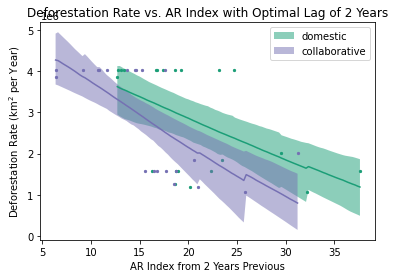

/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/1299980782.py:36: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_range = np.float(min(mses.mses_ave) + one_std)


The average MSE of the valuation sets: 1754234534751.0105
This occured when using a polynomial of order: 1


/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y_pred_bootstrap[i] = y_pred
/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y_pred_bootstrap[i] = y_pred
/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor pe

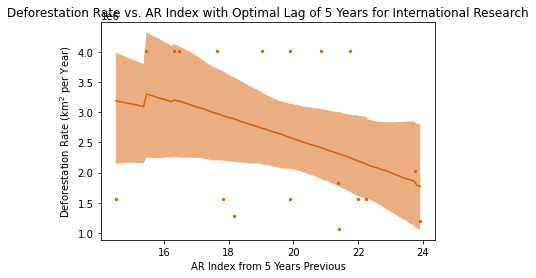

In [233]:
response = 'forest_loss_in_km'
poly_order_max = 5


variable_of_interest = 'AR_Index_2_Year_Prev'

[y_bootstrap_summary_domestic, x_array_domestic, MSE_min_domestic, optimal_poly_order_domestic] = bootstrap_polynomial_analysis(domestic_df_list[2], variable_of_interest, response, poly_order_max, len(domestic_df_list[2]))

plt.scatter(domestic_df_list[2][variable_of_interest], domestic_df_list[2][response], s=5, color=c_d)
plt.plot(x_array_domestic, y_bootstrap_summary_domestic['median'], c_d)
plt.fill_between(x_array_domestic, y_bootstrap_summary_domestic['95_CI_low'], y_bootstrap_summary_domestic['95_CI_high'], facecolor = c_d, alpha = 0.5, label='domestic')

[y_bootstrap_summary_collaborative, x_array_collaborative, MSE_min_collaborative, optimal_poly_order_collaborative] = bootstrap_polynomial_analysis(collaborative_df_list[2], variable_of_interest, response, poly_order_max, len(collaborative_df_list[2]))
plt.scatter(collaborative_df_list[2][variable_of_interest], collaborative_df_list[2][response], s=5, color=c_c)
plt.plot(x_array_collaborative, y_bootstrap_summary_collaborative['median'], c_c)
plt.fill_between(x_array_collaborative, y_bootstrap_summary_collaborative['95_CI_low'], y_bootstrap_summary_collaborative['95_CI_high'], facecolor = c_c, alpha = 0.5, label='collaborative')

plt.xlabel('AR Index from 2 Years Previous')
plt.ylabel(f'Deforestation Rate (km$^2$ per Year)')
plt.title(f'Deforestation Rate vs. AR Index with Optimal Lag of 2 Years')
plt.legend()
plt.show()



variable_of_interest = 'AR_Index_5_Year_Prev'

[y_bootstrap_summary_international, x_array_international, MSE_min_international, optimal_poly_order_international] = bootstrap_polynomial_analysis(international_df_list[5], variable_of_interest, response, poly_order_max, len(international_df_list[5]))
plt.scatter(international_df_list[5][variable_of_interest],international_df_list[5][response], s=5, color=c_i)
plt.plot(x_array_international, y_bootstrap_summary_international['median'], c_i)
plt.fill_between(x_array_international, y_bootstrap_summary_international['95_CI_low'], y_bootstrap_summary_international['95_CI_high'], facecolor = c_i, alpha = 0.5, label='international')
plt.xlabel('AR Index from 5 Years Previous')
plt.ylabel(f'Deforestation Rate (km$^2$ per Year)')
plt.title(f'Deforestation Rate vs. AR Index with Optimal Lag of 5 Years for International Research')
plt.show()

/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/1299980782.py:36: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_range = np.float(min(mses.mses_ave) + one_std)


The average MSE of the valuation sets: 2.649065443606019
This occured when using a polynomial of order: 1


/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y_pred_bootstrap[i] = y_pred
/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y_pred_bootstrap[i] = y_pred
/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor pe

The average MSE of the valuation sets: 1.4545224116437068
This occured when using a polynomial of order: 1


/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y_pred_bootstrap[i] = y_pred
/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y_pred_bootstrap[i] = y_pred
/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor pe

The average MSE of the valuation sets: 2.825072987302402
This occured when using a polynomial of order: 1


/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y_pred_bootstrap[i] = y_pred
/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y_pred_bootstrap[i] = y_pred
/var/folders/xj/85bvs1tn7gqfbyxmrt5t_krc0000gn/T/ipykernel_88608/2425233294.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor pe

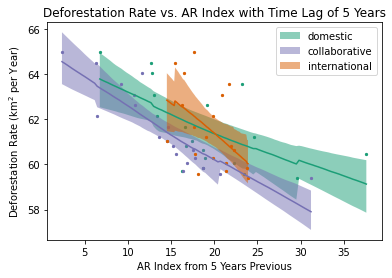

In [68]:
variable_of_interest = 'AR_Index_5_Year_Prev'


[y_bootstrap_summary_domestic, x_array_domestic, MSE_min_domestic, optimal_poly_order_domestic] = bootstrap_polynomial_analysis(domestic_df_list[5], variable_of_interest, response, poly_order_max, len(domestic_df_list[5]))

plt.scatter(domestic_df_list[5][variable_of_interest], domestic_df_list[5][response], s=5, color=c_d)
plt.plot(x_array_domestic, y_bootstrap_summary_domestic['median'], c_d)
plt.fill_between(x_array_domestic, y_bootstrap_summary_domestic['95_CI_low'], y_bootstrap_summary_domestic['95_CI_high'], facecolor = c_d, alpha = 0.5, label='domestic')

[y_bootstrap_summary_collaborative, x_array_collaborative, MSE_min_collaborative, optimal_poly_order_collaborative] = bootstrap_polynomial_analysis(collaborative_df_list[5], variable_of_interest, response, poly_order_max, len(collaborative_df_list[5]))
plt.scatter(collaborative_df_list[5][variable_of_interest], collaborative_df_list[5][response], s=5, color=c_c)
plt.plot(x_array_collaborative, y_bootstrap_summary_collaborative['median'], c_c)
plt.fill_between(x_array_collaborative, y_bootstrap_summary_collaborative['95_CI_low'], y_bootstrap_summary_collaborative['95_CI_high'], facecolor = c_c, alpha = 0.5, label='collaborative')

[y_bootstrap_summary_international, x_array_international, MSE_min_international, optimal_poly_order_international] = bootstrap_polynomial_analysis(international_df_list[5], variable_of_interest, response, poly_order_max, len(international_df_list[5]))
plt.scatter(international_df_list[5][variable_of_interest],international_df_list[5][response], s=5, color=c_i)
plt.plot(x_array_international, y_bootstrap_summary_international['median'], c_i)
plt.fill_between(x_array_international, y_bootstrap_summary_international['95_CI_low'], y_bootstrap_summary_international['95_CI_high'], facecolor = c_i, alpha = 0.5, label='international')

plt.xlabel('AR Index from 5 Years Previous')
plt.ylabel(f'Deforestation Rate (km$^2$ per Year)')
plt.title(f'Deforestation Rate vs. AR Index with Time Lag of 5 Years')
plt.legend()
plt.show()